# segmentation

In [1]:
import yaml
from pathlib import Path
import ipywidgets as widgets

with open('../vessel_density_local/config.yml', 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

seg_dir = Path(cfg['paths']['segmentation'])
results = {i.name: i for i in seg_dir.iterdir()}
select_widget = widgets.Select(
    options=results.keys(),
    description='Segmentation results:',
    layout=widgets.Layout(width='90%'),
    style={'description_width': 'initial'}
)

display(select_widget)

Select(description='Segmentation results:', layout=Layout(width='90%'), options=('Nude34_Z4-10x10Tile-z-2-Line…

In [5]:
from CrystalTracer3D.io import CrystalReader
import numpy as np
import pandas as pd


res_dir = results[select_widget.value]
reader = CrystalReader(seg_dir.parent / 'raw' / f'{select_widget.value}.czi')
vessel_chan = reader.find_channel(cfg['segmentation']['vessel_ch'])
seg_chan = reader.find_channel(cfg['segmentation']['seg_chan'])
sf = cfg['segmentation']['xy_scale']

vessel_raw = reader.assemble_tiles(vessel_chan, sf)
crystal_raw = reader.assemble_tiles(seg_chan, sf)
vessel_seg = np.load(res_dir / 'vessel_local.npy')
crystal_seg = np.load(res_dir / 'crystal.npy')
dists = pd.read_csv(res_dir / 'dist2vessel.csv', index_col='label')

View raw and segmentation in 3D

In [3]:
import napari
viewer = napari.Viewer()
viewer.add_image(vessel_raw, name='vessel_raw')
viewer.add_image(crystal_raw, name='crystal_raw')
viewer.add_labels(vessel_seg, name='vessel_seg')
viewer.add_labels(crystal_seg, name='crystal_seg')
napari.run()

Heatmap of distances to vessel

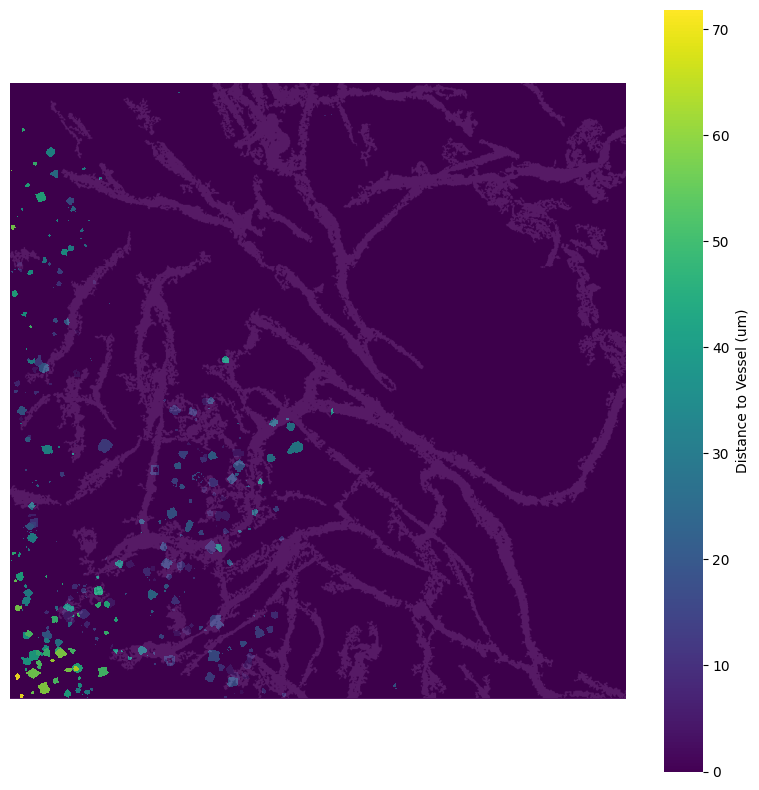

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
vessel_mip = vessel_seg.max(axis=0)
dist_vol = np.zeros_like(crystal_raw, dtype=float)
for ind, row in dists.iterrows():
    dist_vol[crystal_seg == ind] = row['dist']
dist_mip = dist_vol.max(axis=0)

fi, ax = plt.subplots(figsize=(8, 8))
ax.imshow(vessel_mip, cmap='gray', zorder=1)
h = sns.heatmap(
    dist_mip,
    cmap='viridis',
    cbar_kws={'label': 'Distance to Vessel (um)'},
    xticklabels=False,
    yticklabels=False,
    zorder=2,
    cbar=True
)

for mesh in h.collections:
    mesh.set_alpha(0.9)

ax.axis('off')
plt.tight_layout()
plt.show()